# Descripción del proyecto
La compañía móvil Megaline no está satisfecha al ver que muchos de sus clientes utilizan planes heredados. Quieren desarrollar un modelo que pueda analizar el comportamiento de los clientes y recomendar uno de los nuevos planes de Megaline: Smart o Ultra.

Tienes acceso a los datos de comportamiento de los suscriptores que ya se han cambiado a los planes nuevos (del proyecto del sprint de Análisis estadístico de datos). Para esta tarea de clasificación debes crear un modelo que escoja el plan correcto. Como ya hiciste el paso de procesar los datos, puedes lanzarte directo a crear el modelo.

Desarrolla un modelo con la mayor exactitud posible. En este proyecto, el umbral de exactitud es 0.75. Usa el dataset para comprobar la exactitud.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import GridSearchCV

# Carga de Datos

In [2]:
url = 'https://raw.githubusercontent.com/Davichobacter/data_science_tt/refs/heads/main/Sprint_9/data/users_behavior.csv'

In [3]:
df = pd.read_csv(url)

## EDA

### Mostrar Información General

Utiliza `df.info()` para obtener un resumen de la estructura del DataFrame, incluyendo tipos de datos y valores no nulos.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


### Mostrar Estadísticas Descriptivas

Utiliza `df.describe()` para obtener un resumen estadístico de las columnas numéricas del DataFrame, incluyendo la media, desviación estándar, valores mínimos y máximos, y cuartiles.


In [5]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


### Comprobar Valores Faltantes

Verifica la presencia de valores nulos en el DataFrame `df` utilizando `df.isnull().sum()` para obtener un recuento por columna.


In [6]:
df.isnull().sum()

,0
calls,0
minutes,0
messages,0
mb_used,0
is_ultra,0


### Identificar Filas Duplicadas

Identifica y cuenta las filas completamente duplicadas en el DataFrame `df` utilizando `df.duplicated().sum()`.


In [7]:
df.duplicated().sum()

np.int64(0)

### Visualizar la Distribución de las Características Numéricas

Visualiza las distribuciones de las características numéricas ('calls', 'minutes', 'messages', 'mb_used') utilizando histogramas o boxplots para entender su forma, dispersión y posibles valores atípicos.


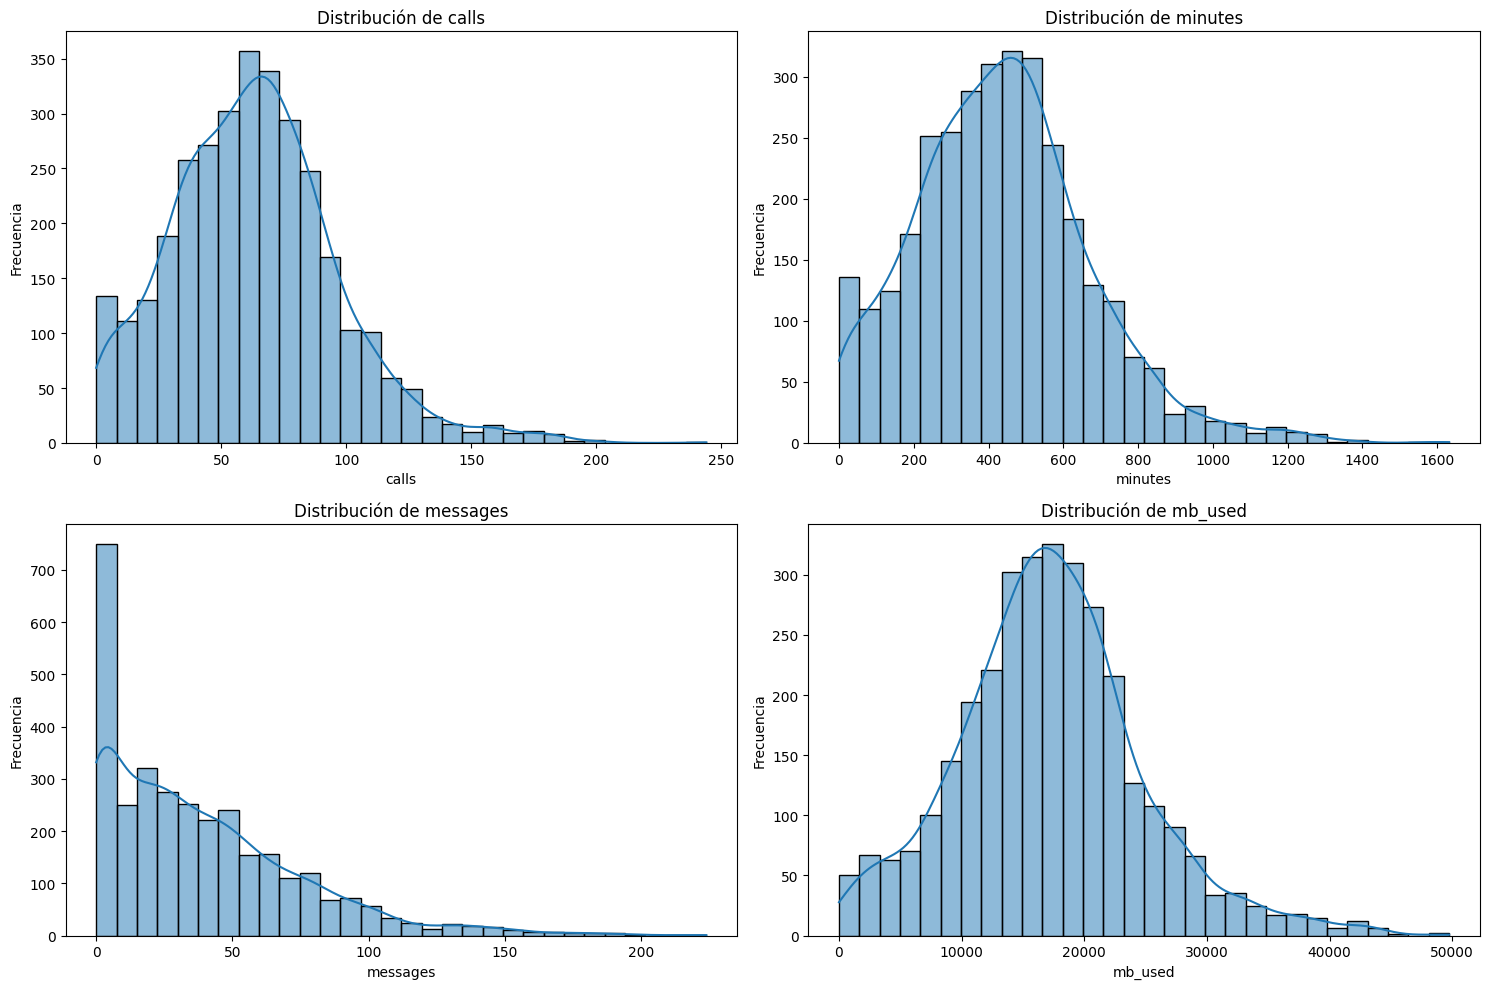

In [8]:
numerical_features = ['calls', 'minutes', 'messages', 'mb_used']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1) # Create a 2x2 grid of subplots
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### Visualizar la Distribución de la Variable Objetivo

Visualiza la distribución de la variable objetivo 'is_ultra' utilizando un diagrama de barras para entender el balance de clases.


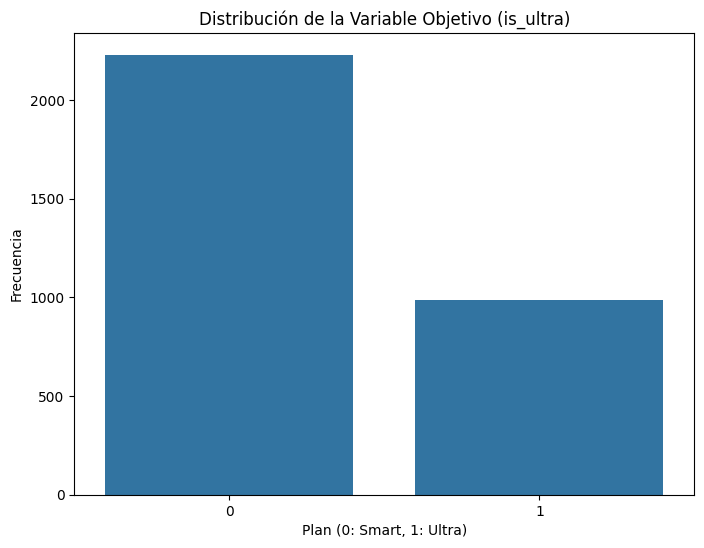

In [9]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_ultra', data=df)
plt.title('Distribución de la Variable Objetivo (is_ultra)')
plt.xlabel('Plan (0: Smart, 1: Ultra)')
plt.ylabel('Frecuencia')
plt.show()

## Summary:

### Data Analysis Key Findings

*   The dataset contains 3214 entries and 5 columns (`calls`, `minutes`, `messages`, `mb_used`, `is_ultra`), all of which are numerical and complete, with no missing values or duplicate rows.
*   Descriptive statistics show that the average user spends approximately 438 minutes on calls and uses around 17207 MB of data per month.
*   The `is_ultra` variable indicates that about 30.6% of users are on the 'Ultra' plan, implying a class imbalance where 'Smart' plan users are more prevalent.
*   The distributions of `calls`, `minutes`, and `mb_used` are somewhat bell-shaped with a slight right skew, while `messages` is highly right-skewed, showing that many users send few or no messages.
*   A very strong positive correlation (0.98) exists between `calls` and `minutes`, which is expected.


# Segmentacion de datos

In [10]:
target = df['is_ultra']
features = df.drop('is_ultra', axis=1)

## Dividir los datos en `entrenamiento` y `temporal`

Divide los 'features' y el 'target' en un conjunto de entrenamiento (70%) y un conjunto temporal (30%) utilizando train_test_split. Asegúrate de usar stratify=target para mantener la proporción de la variable objetivo y un random_state para reproducibilidad.

In [11]:
target_train, target_temp, features_train, features_temp = train_test_split(
    target,
    features,
    test_size=0.3,
    stratify=target,
    random_state=12345
    )

## Dividir `temporal` en `validacion` y `test`

Divide el conjunto temporal resultante del paso anterior en conjuntos de validación (15% del total) y de prueba (15% del total). Utiliza train_test_split nuevamente con stratify y random_state.

In [12]:
target_valid, target_test, features_valid, features_test = train_test_split(
    target_temp,
    features_temp,
    test_size=0.5,
    stratify=target_temp,
    random_state=12345
    )

## Verificar las formas de los conjuntos

Muestra las formas de los conjuntos resultantes (entrenamiento, validación y prueba) para 'features' y 'target' para verificar que la división se realizó correctamente.

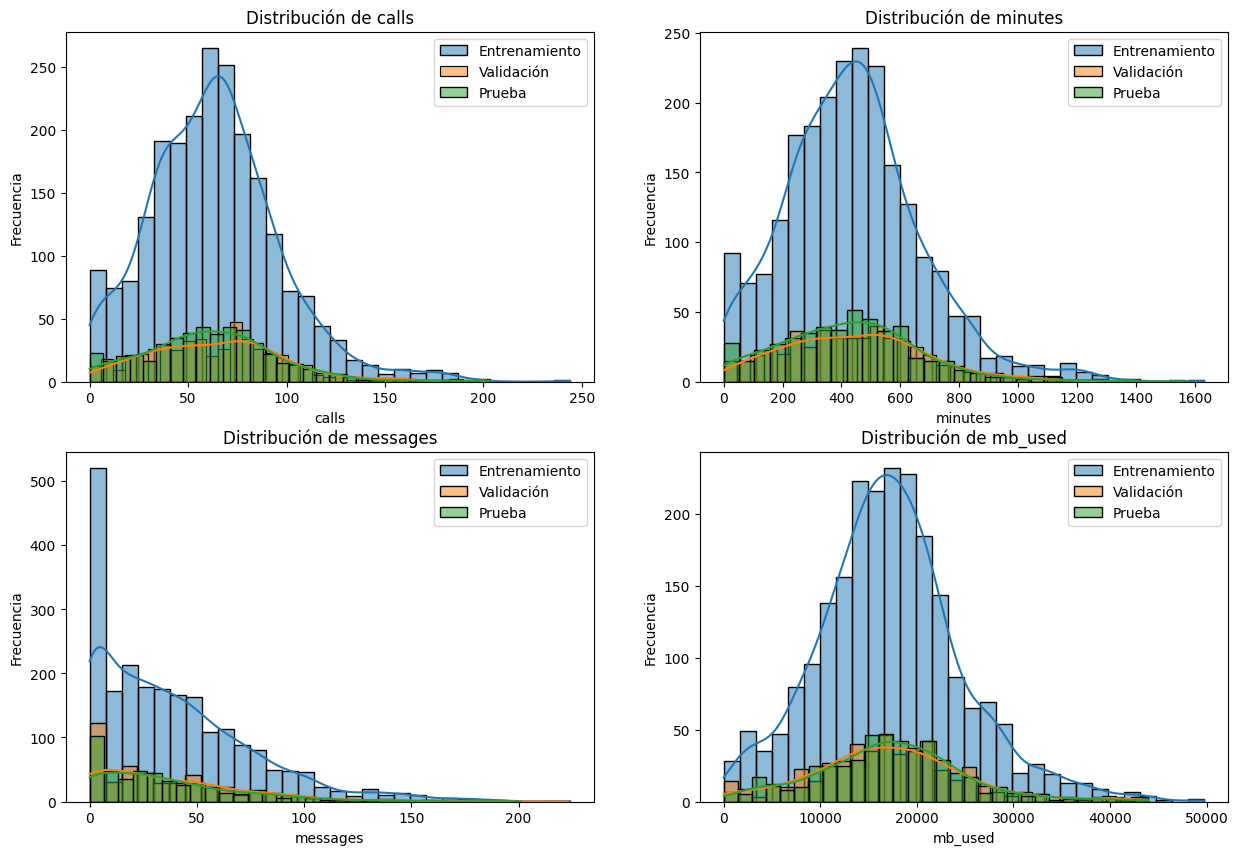

In [13]:
numerical_features = ['calls', 'minutes', 'messages', 'mb_used']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1) # Create a 2x2 grid of subplots
    sns.histplot(features_train[col], kde=True, bins=30, alpha=0.5, label='Entrenamiento')
    sns.histplot(features_valid[col], kde=True, bins=30, alpha=0.5, label='Validación')
    sns.histplot(features_test[col], kde=True, bins=30, alpha=0.5, label='Prueba')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.legend()


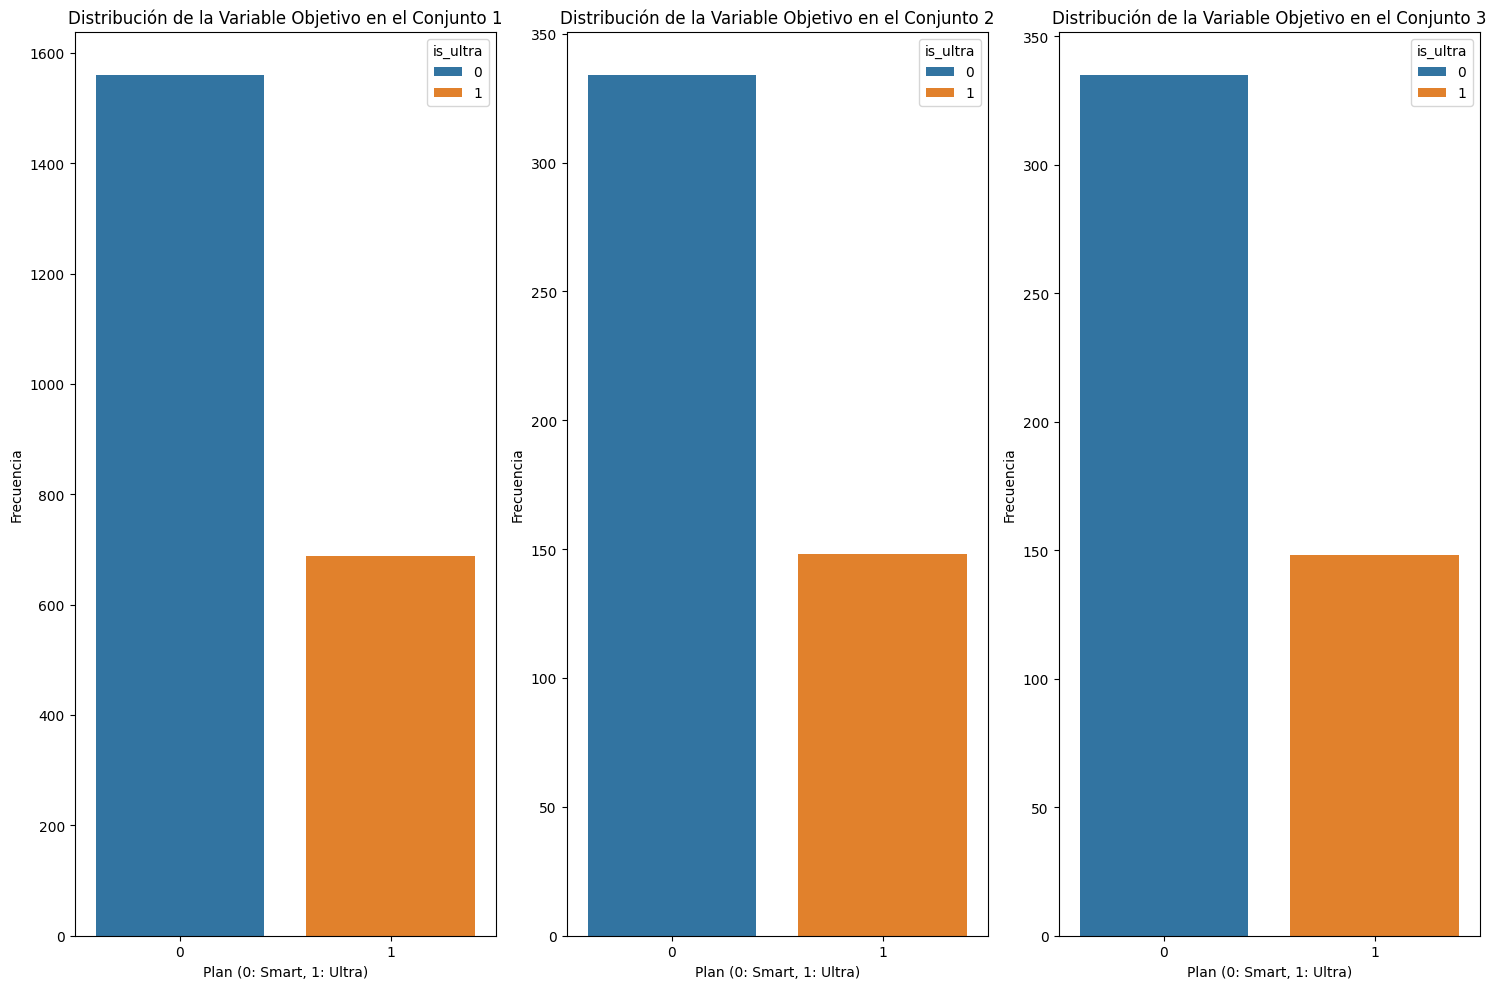

In [14]:
targets_df = [target_train, target_valid, target_test]

plt.figure(figsize=(15, 10))
for i, target in enumerate(targets_df):
    plt.subplot(1, 3, i + 1) # Create a 1x3 grid of subplots
    sns.countplot(x=target, hue=target)
    plt.title(f'Distribución de la Variable Objetivo en el Conjunto {i+1}')
    plt.xlabel('Plan (0: Smart, 1: Ultra)')
    plt.ylabel('Frecuencia')
    plt.tight_layout()
plt.show()

# Probar todos los modelos para generar la clasificación

In [15]:
better_model, better_accuracy = None, 0

# Logistic regression

In [16]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

In [17]:
model = LogisticRegression(random_state=12345)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [18]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [19]:
print("Mejores parámetros:", best_params)
print("Mejor modelo:", best_model)

Mejores parámetros: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Mejor modelo: LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear')


In [20]:
model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=12345)

In [21]:
predictions_valid = model.fit(features_train, target_train).predict(features_valid)

In [22]:
result = mean_squared_error(target_valid, predictions_valid)

print('RECM del modelo de regresión logística:', round(result*100, 2), '%')

RECM del modelo de regresión logística: 27.39 %


In [23]:
better_model = {
    'first_model': {
        'model': model,
        'accuracy': round(result*100, 2)
    }
}

# Decision Tree Classifier

In [24]:
dtc_best_model = None
dtc_best_result = 0
dtc_best_depth = 0

In [25]:
for depth in range(1, 16):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions_valid)
    print(f"Accuracy del modelo de árbol de decisión con profundidad {depth}: {round(result*100, 2)} %")

    if result > dtc_best_result:
        dtc_best_model = model
        dtc_best_result = result
        dtc_best_depth = depth

Accuracy del modelo de árbol de decisión con profundidad 1: 73.44 %
Accuracy del modelo de árbol de decisión con profundidad 2: 79.05 %
Accuracy del modelo de árbol de decisión con profundidad 3: 80.08 %
Accuracy del modelo de árbol de decisión con profundidad 4: 78.42 %
Accuracy del modelo de árbol de decisión con profundidad 5: 80.71 %
Accuracy del modelo de árbol de decisión con profundidad 6: 79.88 %
Accuracy del modelo de árbol de decisión con profundidad 7: 80.08 %
Accuracy del modelo de árbol de decisión con profundidad 8: 79.67 %
Accuracy del modelo de árbol de decisión con profundidad 9: 79.05 %
Accuracy del modelo de árbol de decisión con profundidad 10: 79.05 %
Accuracy del modelo de árbol de decisión con profundidad 11: 78.84 %
Accuracy del modelo de árbol de decisión con profundidad 12: 77.39 %
Accuracy del modelo de árbol de decisión con profundidad 13: 77.8 %
Accuracy del modelo de árbol de decisión con profundidad 14: 76.76 %
Accuracy del modelo de árbol de decisión con

In [26]:
better_model['second_model'] = {
    'model': dtc_best_model,
    'accuracy': round(dtc_best_result*100, 2),
    'depth': dtc_best_depth
}

# Random Forest Classifier

In [27]:
rfc_best_model = None
rfc_best_result = 0
rfc_best_est = 0
rfc_best_depth = 0

In [28]:
for est in range(10, 61, 10):
    for depth in range(1, 61):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions_valid)
        print(f"Accuracy del modelo de bosque aleatorio con {est} estimadores y profundidad {depth}: {round(result*100, 2)} %")

        if result > rfc_best_result:
            rfc_best_model = model
            rfc_best_result = result
            rfc_best_est = est
            rfc_best_depth = depth

Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 1: 77.18 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 2: 79.46 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 3: 81.12 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 4: 81.54 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 5: 81.95 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 6: 80.71 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 7: 80.08 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 8: 80.08 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 9: 80.91 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 10: 79.05 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 11: 79.88 %
Accuracy del modelo de bosque aleatorio con 10 estimadores y profundidad 1

In [29]:
better_model['third_model'] = {
    'model': rfc_best_model,
    'accuracy': round(rfc_best_result*100, 2),
    'est': rfc_best_est,
    'depth': rfc_best_depth
}

# Mejores modelos

In [30]:
for model_name, model_info in better_model.items():
    print(f"{model_name}:")
    print(f"  Modelo: {model_info['model']}")
    print(f"  Accuracy: {model_info['accuracy']}%")


first_model:
  Modelo: LogisticRegression(C=1, penalty='l1', random_state=12345, solver='liblinear')
  Accuracy: 27.39%
second_model:
  Modelo: DecisionTreeClassifier(max_depth=5, random_state=12345)
  Accuracy: 80.71%
third_model:
  Modelo: RandomForestClassifier(max_depth=5, n_estimators=10, random_state=12345)
  Accuracy: 81.95%


## Prueba sobre Logistic Regression

In [31]:
lr_model = LogisticRegression(C=1, penalty='l1', solver='liblinear', random_state=12345)
lr_model.fit(features_train, target_train)

predictions_test_lr = lr_model.predict(features_test)
result_lr = accuracy_score(target_test, predictions_test_lr)

In [32]:
print('Accuracy del modelo de regresión logística en el conjunto de prueba:', round(result_lr*100, 2), '%')

Accuracy del modelo de regresión logística en el conjunto de prueba: 75.16 %


## Prueba sobre Decision Tree Classifier

In [33]:
dtc_model = DecisionTreeClassifier(random_state=12345, max_depth=5)
dtc_model.fit(features_train, target_train)

predictions_test_dtc = dtc_model.predict(features_test)
result_dtc = accuracy_score(target_test, predictions_test_dtc)

In [34]:
print('Accuracy del modelo de árbol de decisión en el conjunto de prueba:', round(result_dtc*100, 2), '%')

Accuracy del modelo de árbol de decisión en el conjunto de prueba: 79.3 %


## Prueba sobre Random Forest Classifier

In [35]:
rfc_model = RandomForestClassifier(random_state=12345, max_depth=5, n_estimators=10)
rfc_model.fit(features_train, target_train)

predictions_test_rfc = rfc_model.predict(features_test)
result_rfc = accuracy_score(target_test, predictions_test_rfc)

In [36]:
print('Accuracy del modelo de bosque aleatorio en el conjunto de prueba:', round(result_rfc*100, 2), '%')

Accuracy del modelo de bosque aleatorio en el conjunto de prueba: 81.37 %
